# Decentmon data preparation

In [2]:
import pandas as pd

from decmon.constants import *
from decmon.df_utils import *
from decmon.filter import *
from decmon.plotter import *

In [3]:
SUBDIR = 3

In [4]:
path = f"{INPUT_DIR}/{SUBDIR}"

f_df = [load_simulation_data(f"{path}/{i+1}.log") for i in PATTERNS]
f_df[0].head()

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,0,1,3,5,4,6,7,3,1.0,3.74,1.77,12,53,17,"Until (Var ""c"", Var ""a"")",{ |b|c} ; { |b|c} ; { |b| } ; { | | } ; {a| |...
1,1,1,2,3,2,3,0,0,1.0,0.00,0.00,3,3,3,"Next (Var ""c"")",{ | | } ; {a|b|c} ; { |b| } ; {a|b| } ; {a| |...
2,2,1,2,3,3,3,3,2,1.0,3.50,1.66,8,17,12,"Until (Var ""a"", Var ""c"")",{a| | } ; { |b|c} ; {a|b|c} ; { | | } ; {a|b|...
3,3,1,2,3,2,3,2,0,1.0,1.66,0.00,4,8,4,"Glob (Var ""c"")",{ |b|c} ; {a|b| } ; {a| |c} ; {a| |c} ; {a| |...
4,4,1,2,3,2,3,2,0,1.0,1.66,0.00,4,8,4,"Glob (Var ""a"")",{a| | } ; { | |c} ; {a|b|c} ; { |b| } ; { |b|...


In [5]:
strategies_f_df = [split_by_dictionary(f_df[i], STRATEGIES) for i in PATTERNS]

print(f"Datasets: {len(strategies_f_df)}. Strategies: {len(strategies_f_df[0])}. Single dataset Formulae:{len(strategies_f_df[0][0])}")
sep_strat_f_df = [pd.concat(strategies_f_df[i], ignore_index=True) for i in PATTERNS]
sep_strat_f_df[0].head()

Datasets: 8. Strategies: 3. Single dataset Formulae:3073


,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,0,1,3,6,1.0,12,"Until (Var ""c"", Var ""a"")",{ |b|c} ; { |b|c} ; { |b| } ; { | | } ; {a| |...,orchestration
1,1,1,2,3,1.0,3,"Next (Var ""c"")",{ | | } ; {a|b|c} ; { |b| } ; {a|b| } ; {a| |...,orchestration
2,2,1,2,3,1.0,8,"Until (Var ""a"", Var ""c"")",{a| | } ; { |b|c} ; {a|b|c} ; { | | } ; {a|b|...,orchestration
3,3,1,2,3,1.0,4,"Glob (Var ""c"")",{ |b|c} ; {a|b| } ; {a| |c} ; {a| |c} ; {a| |...,orchestration
4,4,1,2,3,1.0,4,"Glob (Var ""a"")",{a| | } ; { | |c} ; {a|b|c} ; { |b| } ; { |b|...,orchestration


In [6]:
merged_metrics_df = [extract_metrics(sep_strat_f_df[i]) for i in PATTERNS]
merged_metrics_df[0].max()

formula_id             3072
strategy      orchestration
value                5120.0
metric            trace_len
dtype: object

## Formula Encoding

In [7]:
df_f_ops = [extract_ops(sep_strat_f_df[i]) for i in PATTERNS]
df_f_ops[0].head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,10,-3,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,-1,-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


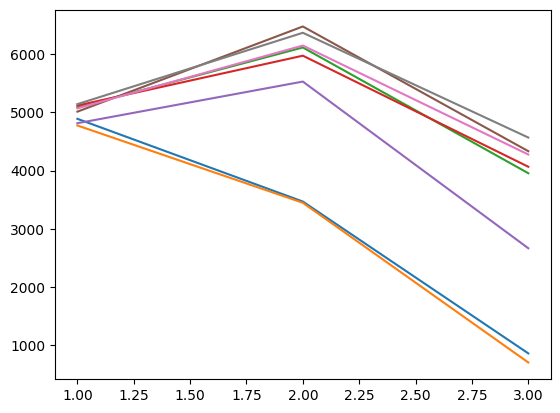

In [8]:
plot_atoms_variation(df_f_ops, SUBDIR)

## Plotting

In [9]:
# for i in PATTERNS:
#     grid_plot = plot_grid_barplots(merged_metrics_df[i], grid_cell_field= 'metric',
#               y_axis = 'value', x_axis = 'strategy',
#               order = ['orchestration', 'migration', 'choreography'])

#grid_plot.savefig("output/out.png")

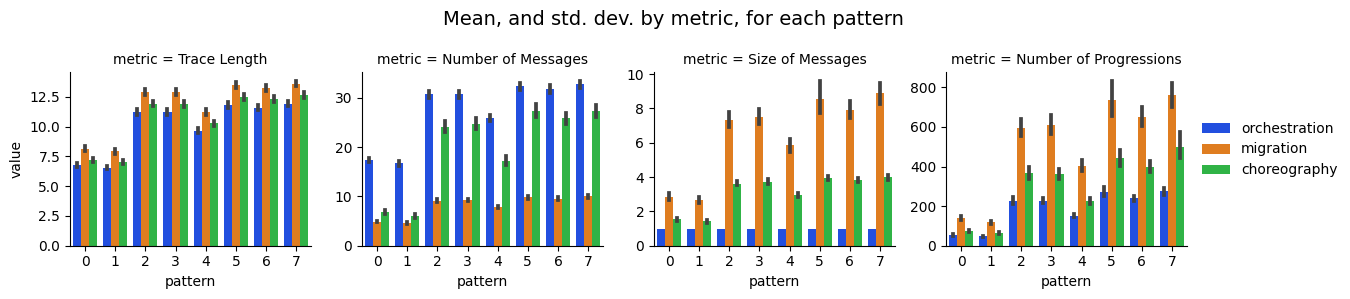

In [10]:
merged_metrics_dfp = prepare_with_pattern(merged_metrics_df)
plot = plot_metrics_by_patterns(merged_metrics_dfp)
plot.savefig(f"output/pattern_{SUBDIR}.png")
plot

In [11]:
expanded_f_df = [sep_strat_f_df[i].merge(df_f_ops[i], left_index=True, right_index=True) for i in PATTERNS]
expanded_f_df[0].head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,79,80,81,82,83,84,85,86,87,88
0,0,1,3,6,1.0,12,"Until (Var ""c"", Var ""a"")",{ |b|c} ; { |b|c} ; { |b| } ; { | | } ; {a| |...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,3,1.0,3,"Next (Var ""c"")",{ | | } ; {a|b|c} ; { |b| } ; {a|b| } ; {a| |...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,3,1.0,8,"Until (Var ""a"", Var ""c"")",{a| | } ; { |b|c} ; {a|b|c} ; { | | } ; {a|b|...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,3,1.0,4,"Glob (Var ""c"")",{ |b|c} ; {a|b| } ; {a| |c} ; {a| |c} ; {a| |...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,3,1.0,4,"Glob (Var ""a"")",{a| | } ; { | |c} ; {a|b|c} ; { |b| } ; { |b|...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
for i in PATTERNS:
    expanded_f_df[i].strategy = pd.Categorical(expanded_f_df[i].strategy)
    expanded_f_df[i]['strategy_id'] = expanded_f_df[i].strategy.cat.codes

full_scale_df_3 = pd.concat(expanded_f_df)
full_scale_df_3.head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,355,356,357,358,359,360,361,362,363,364
0,0,1,3,6,1.0,12,"Until (Var ""c"", Var ""a"")",{ |b|c} ; { |b|c} ; { |b| } ; { | | } ; {a| |...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,3,1.0,3,"Next (Var ""c"")",{ | | } ; {a|b|c} ; { |b| } ; {a|b| } ; {a| |...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,3,1.0,8,"Until (Var ""a"", Var ""c"")",{a| | } ; { |b|c} ; {a|b|c} ; { | | } ; {a|b|...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,3,1.0,4,"Glob (Var ""c"")",{ |b|c} ; {a|b| } ; {a| |c} ; {a| |c} ; {a| |...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,3,1.0,4,"Glob (Var ""a"")",{a| | } ; { | |c} ; {a|b|c} ; { |b| } ; { |b|...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# TODO:
# -- pycaret for classification
# Action points
# - higher number of nodes (5, 7, 9?)
# - statistics about the learning
# - test other algorithms (pycaret)
